In [1]:
import hdbscan
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random

from node2vec import Node2Vec
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from umap.umap_ import UMAP

ModuleNotFoundError: No module named 'hdbscan'

In [2]:
# Load the edge list
df = pd.read_csv(
    'soc-sign-bitcoinotc.csv',
    header=None,
    names=['source','target','rating','timestamp']
)

In [3]:
# Build an undirected graph
G = nx.from_pandas_edgelist(df, source='source', target='target', create_using=nx.Graph())

In [4]:
# Initialize Node2Vec model
n2v = Node2Vec(
    graph=G,
    dimensions=64,    # embedding size
    walk_length=30,   # nodes per walk
    num_walks=100,    # walks per node
    p=1,              # return hyperparameter
    q=1,              # in-out hyperparameter
    workers=4         # parallel workers
)

Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:27<00:00,  1.11s/it]


In [5]:
# Fit the model
model = n2v.fit(
    window=10,       # context window size for Word2Vec
    min_count=1,
    batch_words=4
)

In [6]:
# Extract embeddings into a DataFrame
nodes = model.wv.index_to_key
embeddings = model.wv.vectors

df_embed = pd.DataFrame(embeddings, index=nodes)
df_embed.index.name = 'node'
df_embed.reset_index(inplace=True)
df_embed.columns = ['node'] + [f'emb_{i}' for i in range(df_embed.shape[1]-1)]

In [7]:
# Save to CSV
output_path = 'node2vec_embeddings.csv'
df_embed.to_csv(output_path, index=False)

print(f"Saved {len(df_embed)}×{embeddings.shape[1]} embeddings to {output_path}")
print(df_embed.head())

Saved 5881×64 embeddings to node2vec_embeddings.csv
   node     emb_0     emb_1     emb_2     emb_3     emb_4     emb_5     emb_6  \
0    35 -0.009817 -0.096486 -0.300090  0.210527 -0.209326 -0.235928  0.252973   
1  2125 -0.001011  0.061155  0.063402  0.409484 -0.342134  0.144455  0.061421   
2  2642 -0.076543  0.361902  0.409329 -0.035570 -0.492301 -0.382901  0.047366   
3  1810  0.215682  0.044848  0.346824  0.099685 -0.262268 -0.115490 -0.201684   
4  2028  0.237684 -0.153782 -0.042848  0.215890 -0.077207 -0.286538  0.330776   

      emb_7     emb_8  ...    emb_54    emb_55    emb_56    emb_57    emb_58  \
0  0.167418 -0.175276  ...  0.135669 -0.321643  0.075336 -0.431944 -0.193827   
1  0.302993 -0.193152  ...  0.195432 -0.259323 -0.176727 -0.395155  0.179930   
2 -0.250028 -0.041615  ...  0.333385 -0.187342 -0.328212 -0.446724 -0.372100   
3  0.214607  0.210846  ...  0.144164 -0.082128  0.105108 -0.466108 -0.027350   
4 -0.303926 -0.445020  ...  0.164616  0.011330 -0.021370 -0.5

In [9]:
# Load embeddings
df_embed = pd.read_csv('node2vec_embeddings.csv')
X = df_embed.drop('node', axis=1).values

In [56]:
# Hopkins statistic function
def hopkins_statistic(X, n_samples=min(100, 50)):
    X = np.asarray(X)
    n, d = X.shape
    m = min(n_samples, n//2)
    # Sample real points
    idx = random.sample(range(n), m)
    X_sample = X[idx]
    # Generate uniform points
    U = np.random.uniform(np.min(X, axis=0), np.max(X, axis=0), (m, d))
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
    u_dist, _ = nbrs.kneighbors(U)
    w_nbrs = NearestNeighbors(n_neighbors=2).fit(X)
    w_dist, _ = w_nbrs.kneighbors(X_sample)
    w_dist = w_dist[:, 1].reshape(-1, 1)
    H = np.sum(u_dist) / (np.sum(u_dist) + np.sum(w_dist))
    return H


# Scale embeddings
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Hopkins on scaled data
H_scaled = hopkins_statistic(X_scaled)
print(f'Hopkins (scaled): {H_scaled:.3f}')

# Dimensionality reduction with PCA (retain 90% variance)
pca = PCA(n_components=0.90, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f'PCA reduced dimensions: {X_pca.shape[1]}')

# Hopkins on PCA-reduced data
H_pca = hopkins_statistic(X_pca)
print(f'Hopkins (PCA): {H_pca:.3f}')

# Try density-based clustering if clusterable
if H_pca < 0.5:
    db = DBSCAN(eps=0.5, min_samples=5).fit(X_pca)
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    print(f'DBSCAN found {n_clusters} clusters')
else:
    print("Data still not clusterable — consider tuning embedding hyperparameters or trying alternative distance metrics.")

Hopkins (scaled): 0.839
PCA reduced dimensions: 53
Hopkins (PCA): 0.840
Data still not clusterable — consider tuning embedding hyperparameters or trying alternative distance metrics.


In [60]:
def embed_and_cluster(p, q, dims):
    # Train node2vec
    n2v = Node2Vec(
        graph=G,
        dimensions=dims,
        walk_length=30,
        num_walks=100,
        p=p,
        q=q,
        workers=4
    )
    model = n2v.fit(window=10, min_count=1, batch_words=4)
    emb = model.wv.vectors    # shape (n_nodes, dims)
    
    # Scale + PCA (90% variance)
    Xs = StandardScaler().fit_transform(emb)
    Xp = PCA(n_components=0.90, random_state=42).fit_transform(Xs)
    
    # Run DBSCAN (Euclidean, default eps/min_samples)
    db = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
    labels = db.fit_predict(Xp)
    
    # Count clusters & noise
    uniq = set(labels)
    noise_count = (labels == -1).sum()
    # remove noise label for cluster count
    n_clusters = len(uniq - {-1})
    
    # Compute silhouette only if valid
    if n_clusters >= 2 and (labels != -1).sum() >= 2:
        mask = labels != -1
        sil = silhouette_score(Xp[mask], labels[mask], metric='euclidean')
    else:
        sil = -1.0
    
    return sil, n_clusters, noise_count

# Now sweep p, q, dims
results = []
for p in [0.25, 0.5, 1, 2, 4]:
    for q in [0.25, 0.5, 1, 2, 4]:
        for dims in [16, 32, 64]:
            sil, nc, noise = embed_and_cluster(p, q, dims)
            results.append({
                'p': p, 'q': q, 'dims': dims,
                'silhouette': sil,
                'n_clusters': nc,
                'n_noise': noise
            })

import pandas as pd
df_results = pd.DataFrame(results)
# Sort by silhouette descending
df_results.sort_values('silhouette', ascending=False, inplace=True)
print(df_results.head(10))

Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.36s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:35<00:00,  1.43s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:42<00:00,  1.72s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:42<00:00,  1.71s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:37<00:00,  1.49s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:53<00:00,  2.13s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:57<00:00,  2.29s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [01:01<00:00,  2.46s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [01:02<00:00,  2.51s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [01:32<00:00,  3.69s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 25/25 [01:07<00:00,  2.70s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.38s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:53<00:00,  2.12s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:54<00:00,  2.17s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:56<00:00,  2.27s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:55<00:00,  2.20s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:56<00:00,  2.25s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:56<00:00,  2.26s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [01:02<00:00,  2.49s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:37<00:00,  1.48s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:38<00:00,  1.53s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:35<00:00,  1.42s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:31<00:00,  1.27s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.28s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.30s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.32s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.33s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.32s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 25/25 [00:35<00:00,  1.41s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.37s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:33<00:00,  1.35s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.36s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:35<00:00,  1.44s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:34<00:00,  1.39s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:30<00:00,  1.22s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:31<00:00,  1.25s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:31<00:00,  1.26s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:30<00:00,  1.24s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 3): 100%|██████████| 25/25 [00:33<00:00,  1.34s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:32<00:00,  1.31s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:38<00:00,  1.54s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:40<00:00,  1.63s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:36<00:00,  1.45s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:38<00:00,  1.55s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:39<00:00,  1.58s/it]


Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:39<00:00,  1.58s/it]


       p     q  dims  silhouette  n_clusters  n_noise
13  0.25  4.00    32    0.898525           2     5866
12  0.25  4.00    16    0.762148          67     4649
6   0.25  1.00    16    0.761963          63     4693
27  0.50  4.00    16    0.754066          55     4726
9   0.25  2.00    16    0.753994          66     4671
42  1.00  4.00    16    0.744763          53     4791
21  0.50  1.00    16    0.741747          45     4873
24  0.50  2.00    16    0.738831          53     4775
15  0.50  0.25    16    0.737253          36     4977
3   0.25  0.50    16    0.732990          51     4804


In [64]:
p_best, q_best, dims_best = 0.25, 4.0, 16

# Re-embed with best p, q, dims
n2v = Node2Vec(G, dimensions=dims_best,
               walk_length=30, num_walks=100,
               p=p_best, q=q_best, workers=4)
model = n2v.fit(window=10, min_count=1, batch_words=4)
emb = model.wv.vectors

# Scale + PCA → 90% var
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Xs = StandardScaler().fit_transform(emb)
Xp = PCA(n_components=0.90, random_state=42).fit_transform(Xs)

Computing transition probabilities:   0%|          | 0/5881 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


In [104]:
# Rescale
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)    # X is your raw embeddings

# PCA to, say, 10 dimensions
pca = PCA(n_components=10, random_state=42)
Xp10 = pca.fit_transform(X_scaled)
print("New shape:", Xp10.shape)      # should be (5881, 10)

# Inspect explained variance
print("Explained variance ratio (first 5 PCs):", pca.explained_variance_ratio_[:5])
print("Total explained variance:", pca.explained_variance_ratio_.sum())

# Try DBSCAN immediately
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.5, min_samples=10)
labels = db.fit_predict(Xp10)

print("Clusters:", len(set(labels)-{-1}), " Noise:", (labels==-1).sum())

New shape: (5881, 10)
Explained variance ratio (first 5 PCs): [0.06661282 0.04624128 0.04107063 0.03021525 0.02782821]
Total explained variance: 0.3298425557428057
Clusters: 4  Noise: 5694


In [106]:
results = []
# Scan eps from small to moderate, and a few min_samples values
for eps in np.linspace(0.1, 1.0, 10):     # 0.1, 0.2, … ,1.0
    for ms in [3, 5, 10, 20]:
        db    = DBSCAN(eps=eps, min_samples=ms, metric='euclidean')
        lbl   = db.fit_predict(Xp10)
        n_cl  = len(set(lbl) - {-1})
        n_n   = (lbl == -1).sum()
        sil   = -1.0
        if n_cl >= 2 and (lbl != -1).sum() > 1:
            sil = silhouette_score(Xp10[lbl!=-1], lbl[lbl!=-1])
        results.append((eps, ms, n_cl, n_n, sil))

df = pd.DataFrame(results,
                  columns=['eps','min_samples','n_clusters','n_noise','silhouette'])
# Keep only the runs that actually produced ≥2 clusters
df = df[df.n_clusters >= 2]
# Sort by best silhouette, then most clusters, then fewest noise
df = df.sort_values(['silhouette','n_clusters','n_noise'],
                    ascending=[False,False,True])
print(df.head(10))

    eps  min_samples  n_clusters  n_noise  silhouette
23  0.6           20           2     5616    0.900889
27  0.7           20           4     5413    0.863686
18  0.5           10           4     5694    0.841853
31  0.8           20           6     5274    0.836831
22  0.6           10           7     5479    0.824586
35  0.9           20           9     5154    0.814484
26  0.7           10           9     5276    0.808118
39  1.0           20           9     5125    0.806517
17  0.5            5           7     5620    0.794947
8   0.3            3           3     5871    0.755664


/Users/austinmaxwell/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/austinmaxwell/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


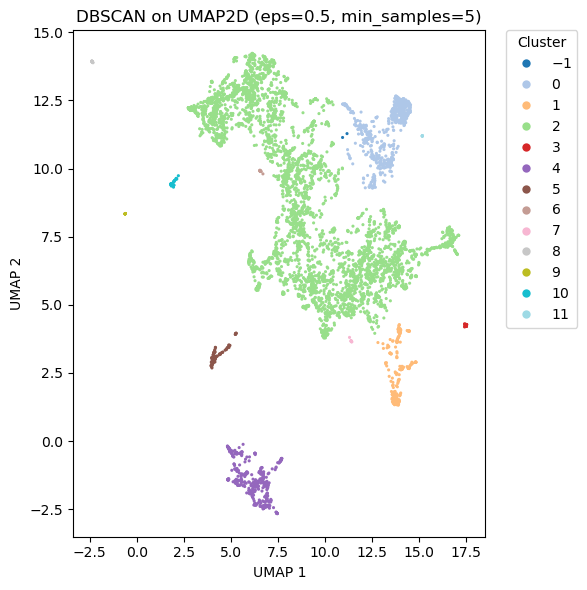

In [116]:
# Project PCA-10D down to 2D
umap2d = UMAP(n_components=2, random_state=42).fit_transform(Xp10)

# DBSCAN in 2D with a small min_samples
db2     = DBSCAN(eps=0.5, min_samples=5)  
labels2 = db2.fit_predict(umap2d)

# Plot with legend
fig, ax = plt.subplots(figsize=(6,6))
scatter = ax.scatter(
    umap2d[:,0], umap2d[:,1],
    c=labels2, cmap='tab20', s=5, linewidths=0
)

# Build legend handles & labels
handles, labl = scatter.legend_elements()
ax.legend(
    handles, labl,
    title="Cluster",
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    borderaxespad=0
)

ax.set_title("DBSCAN on UMAP2D (eps=0.5, min_samples=5)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
plt.tight_layout()
plt.show()

In [120]:
# Project to 2D and cluster
umap2d = UMAP(n_components=2, random_state=42).fit_transform(Xp10)
db2     = DBSCAN(eps=0.5, min_samples=5)
labels2 = db2.fit_predict(umap2d)

# Build a DataFrame mapping each node → its 2D cluster
df2d = pd.DataFrame({
    'node': df_embed['node'],
    'cluster2d': labels2
})

# Load your BTC-OTC edge list
edges = pd.read_csv(
    'soc-sign-bitcoinotc.csv',
    header=None,
    names=['source','target','rating','timestamp']
)

# Compute per-node rating stats
src = edges.groupby('source').rating.agg(out_count='size', avg_out='mean')
tgt = edges.groupby('target').rating.agg(in_count='size',  avg_in='mean')

# Merge everything
node2d = (
    df2d.set_index('node')
        .join(src, how='left')
        .join(tgt, how='left')
        .fillna(0)
        .reset_index()
)

# Summarize by 2D-cluster
summary2d = (node2d
    .groupby('cluster2d')
    .agg(
      size      = ('node','count'),
      avg_out   = ('avg_out','mean'),
      avg_in    = ('avg_in','mean'),
      total_out = ('out_count','sum'),
      total_in  = ('in_count','sum')
    )
    .sort_values('size', ascending=False)
)
print(summary2d)

/Users/austinmaxwell/opt/anaconda3/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/austinmaxwell/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


           size   avg_out    avg_in  total_out  total_in
cluster2d                                               
 2         4200  1.520021  0.894044    29135.0   29223.0
 0          656  1.195545  1.222256     2021.0    2024.0
 4          456  1.353360  1.097102     1937.0    1936.0
 1          292 -0.916777 -4.173332     1380.0    1408.0
 5          125  0.803600  1.344825      327.0     240.0
 3           49  2.022788  1.748984      353.0     344.0
 10          37  1.812830  1.773198      106.0     108.0
 8           18  2.515850  2.178571       83.0      67.0
 9           15  2.121212  1.872727       25.0      25.0
 6           13  1.641893  1.167003      150.0     144.0
 7           12  2.358772  1.563739       56.0      55.0
 11           6  0.166667  1.000000        6.0       6.0
-1            2  1.227273  1.545455       13.0      12.0


**Roles**
| Cluster | Color (in your legend) | Size | avg\_out | avg\_in | Interpretation                                                                                                                                                                                    |
| :-----: | :--------------------: | ---: | -------: | ------: | :------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
|  **2**  |          Green         | 4200 |     1.52 |    0.89 | **Everyday traders.** This is the vast majority of nodes. They give modestly positive trust and receive modestly positive trust. Think casual users who both rate and get rated a bit above zero. |
|  **0**  |       Light blue       |  656 |     1.20 |    1.22 | **Well-liked regulars.** A mid-sized community with slightly higher incoming than outgoing trust—reliable counter-parties who tend to earn a bit more trust than they give.                       |
|  **4**  |         Purple         |  456 |     1.35 |    1.10 | **Optimistic raters.** They give out more trust than they get back, perhaps generous raters giving their first rating or connectors linking groups.                                                             |
|  **1**  |         Orange         |  292 |    –0.92 |   –4.17 | **Distrusted cluster.** Net negative both in giving and receiving: these are the accounts that get flagged and flag others. Possible scammers or users with poor reputations.                       |
|  **5**  |          Brown         |  125 |     0.80 |    1.34 | **Trust-recipients.** They receive substantially more trust than they give, perhaps new users who haven’t had many opportunities yet to rate others.                                               |
|  **3**  |           Red          |   49 |     2.02 |    1.75 | **Trusted core.** A small clique of highly active, highly trusted users. They give very high ratings and get very high ratings back.                                                              |
|  **10** |          Teal          |   37 |     1.81 |    1.77 | **Elite traders.** Similar to cluster 3 but even tighter—power users with excellent reputations on both sides.                                                                                    |
|  **8**  |          Gray          |   18 |     2.52 |    2.18 | **Super-trusted givers.** They almost always assign top marks (avg\_out >2) and earn top marks in return. Very small, very elite.                                                                 |
|  **9**  |         Yellow         |   15 |     2.12 |    1.87 | **High-trust hubs.** Another tiny, highly positive cluster, likely “hubs” in the network who both give and get excellent scores.                                                                   |
|  **6**  |       Light green      |   13 |     1.64 |    1.17 | **Moderate elites.** A micro-cluster of users with above-average outgoing trust but more modest incoming.                                                                                         |
|  **7**  |          Pink          |   12 |     2.36 |    1.56 | **Generous, selective.** They give very high trust but receive a bit less in return.                                                                                                              |
|  **11** |          Cyan          |    6 |     0.17 |    1.00 | **Quiet but trusted.** Very few ratings given (avg\_out ≈0.17) but what little they do they do right and they’re trusted by others.                                                               |
|  **–1** |      Navy (noise)      |    2 |     1.23 |    1.55 | **Outliers.** Only two nodes didn’t fit any dense region; they have small volumes of mostly positive interactions.                                                                                |


In [124]:
summary2d.to_csv('cluster_summary_2d.csv', index=True, index_label='cluster2d')
print("Wrote cluster summary to cluster_summary_2d.csv")

Wrote cluster summary to cluster_summary_2d.csv
